# gis-utils demo
This notebook illustrates some of the basic functionality of ``gis-utils``

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gp
import rasterio
import gisutils
import matplotlib.pyplot as plt

## Working with shapefiles

In [2]:
#nhdplus_path = Path.home() / 'Documents/NHDPlus/'
#files = [nhdplus_path / 'NHDPlusGL/NHDPlus04/NHDSnapshot/Hydrography/NHDFlowline.shp',
#         nhdplus_path / 'NHDPlusMS/NHDPlus07/NHDSnapshot/Hydrography/NHDFlowline.shp']
files = ['data/NHDPlus04_flowline.shp',
         'data/NHDPlus07_flowline.shp']
# make the output folder
Path('output').mkdir(exist_ok=True)

#### Get the Coordinate Reference System for a shapefile
(as a [``pyproj.CRS``](https://pyproj4.github.io/pyproj/stable/api/crs/crs.html) instance)

In [3]:
crs = gisutils.get_shapefile_crs(files[0])
crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

#### read multiple shapefiles into a single DataFrame

Note: for most applications, [``Geopandas``](https://geopandas.org/index.html) does what ``shp2df`` and ``df2shp`` do and more, with a nicer interface (the ``GeoDataFrame``).


In [4]:
df = gisutils.shp2df(files)


reading data/NHDPlus04_flowline.shp...
--> building dataframe... (may take a while for large shapefiles)

reading data/NHDPlus07_flowline.shp...
--> building dataframe... (may take a while for large shapefiles)


In [5]:
df.head()

,COMID,FDATE,RESOLUTION,GNIS_ID,GNIS_NAME,LENGTHKM,REACHCODE,FLOWDIR,WBAREACOMI,FTYPE,FCODE,SHAPE_LENG,ENABLED,GNIS_NBR,geometry
0,6864647,2009-01-15,Medium,1576655,White River,1.660,04030201000045,With Digitized,14704126,ArtificialPath,55800,0.017482,True,0,LINESTRING Z (-89.26039797189003 44.0320061316...
1,6864643,2009-01-15,Medium,1576655,White River,1.511,04030201000045,With Digitized,14704126,ArtificialPath,55800,0.016776,True,0,LINESTRING Z (-89.27431190520178 44.0400841316...
2,6864493,1999-09-13,Medium,1576655,White River,2.262,04030201000046,With Digitized,0,StreamRiver,46006,0.024154,True,0,LINESTRING Z (-89.29007890517727 44.0500859316...
3,6864485,1999-09-13,Medium,1576655,White River,1.487,04030201000047,With Digitized,0,StreamRiver,46006,0.015162,True,0,LINESTRING Z (-89.2916495718415 44.06035093160...
4,6864481,1999-09-13,Medium,1576655,White River,2.088,04030201000048,With Digitized,0,StreamRiver,46006,0.020705,True,0,LINESTRING Z (-89.2915333718417 44.07573519825...


#### write back out to a shapefile

In [6]:
gisutils.df2shp(df, 'output/combined.shp', crs=4269)

writing output/combined.shp... Done


/Users/aleaf/Documents/GitHub/gisutils/gisutils/shapefile.py:129: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  Type = g.type


#### writing .DBF files
this is probably the most significant thing that ``gisutils`` does that GeoPandas doesn't

In [7]:
gisutils.df2shp(df.drop('geometry', axis=1), 'output/combined.dbf')

writing output/combined.dbf... Done


## Working with Coordinate Reference Systems (CRS)

### Reprojection
No need to specify what type of CRS representation you're using!

##### individual point
from NAD83 Geographic CRS (degrees; EPSG:4269) to NAD83 Albers; (EPSG:5070)

In [8]:
x5070, y5070 = gisutils.project((-91.87370, 34.93738), 4269, 5070)
x5070, y5070

(373687.75066478766, 1327908.7001145734)

In [9]:
gisutils.project((x5070, y5070), 5070, 4269)

(-91.8737, 34.937380000000005)

##### vector of points:
from NAD83 Geographic CRS (degrees; EPSG:4269) to NAD83 Albers; (EPSG:3070)

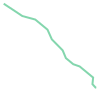

In [10]:
df.geometry.values[0]

In [11]:
x, y = df.geometry.values[0].coords.xy
x, y

(array('d', [-89.26039797189003, -89.2579247052272, -89.25621370522987, -89.25458977189902, -89.25401490523325, -89.25257830523549, -89.25215330523616, -89.25117910523767, -89.25032990523897, -89.24854390524177, -89.24863097190831, -89.24822310524223, -89.2481227719091]),
 array('d', [44.03200613165353, 44.03036993165608, 44.02990519832349, 44.028563798325536, 44.02727593166088, 44.02581819832983, 44.02478959833144, 44.02398473166602, 44.02368973166648, 44.022214198335405, 44.0213375983368, 44.02089139833748, 44.02087259833752]))

In [12]:
x, y = df.geometry.values[0].coords.xy
x3070, y3070 = gisutils.project((x, y), 4269, 3070)
x3070, y3070

(array('d', [579265.1077264423, 579464.9296831822, 579602.5037546933, 579733.9833919932, 579781.3452866407, 579897.9389532936, 579933.0346628772, 580011.9199958814, 580080.2745762386, 580224.9028089752, 580218.8122406754, 580251.9528742861, 580260.0132546861]),
 array('d', [395693.57724608574, 395513.6278105192, 395463.2462046379, 395315.4341270579, 395172.8092087172, 395011.9435474267, 394898.0072433781, 394809.320525229, 394777.17381102033, 394614.5915469667, 394517.1652438268, 394467.9044515705, 394465.88969323505]))

##### shapley geometry object

In [13]:
geom_3070 = gisutils.project(df.geometry.values[0], 4269, 3070)
geom_4269 = gisutils.project(geom_3070, 3070, 4269)
geom_4269.almost_equals(df.geometry.values[0])

/var/folders/4x/bmhyjcdn3mgfdvkk_jgz6bsrlnfk3t/T/ipykernel_51493/3388879590.py:3: ShapelyDeprecationWarning: The 'almost_equals()' method is deprecated and will be removed in Shapely 2.1; use 'equals_exact()' instead
  geom_4269.almost_equals(df.geometry.values[0])


True

##### sequence of shapely geometry objects

In [14]:
projected = gisutils.project(df.geometry, 4269, 3070)

### Raster reprojection

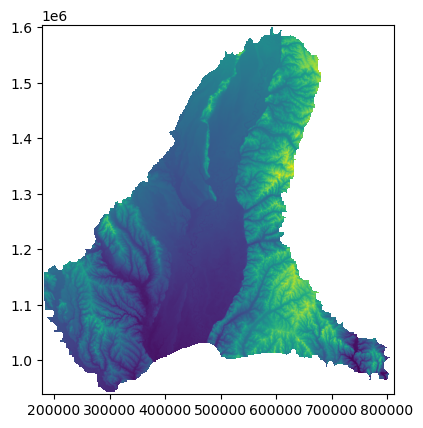

In [15]:
from rasterio.plot import show
rasterfile = 'data/top.tif'

with rasterio.open(rasterfile) as src:
    show(src)

Reproject from NAD83 Albers (EPSG:5070) to NAD83 Geographic CRS (degrees; EPSG:4269)

In [16]:
gisutils.projection.project_raster(rasterfile, 'output/projected.tif', 4269)

reprojecting data/top.tif...
from:
EPSG:5070, res: 1.00e+03, 1.00e+03
to:
EPSG:4269, res: 9.84e-03, 9.84e-03...
wrote output/projected.tif.


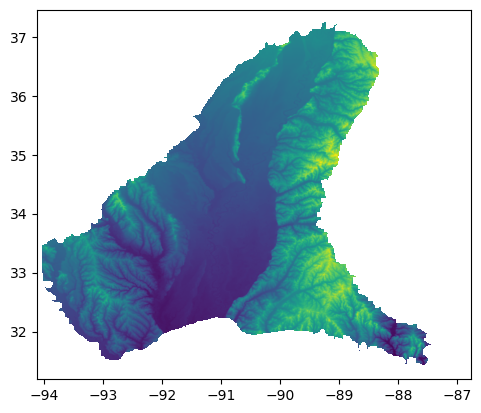

In [17]:
with rasterio.open('output/projected.tif') as src:
    show(src)

#### Note: ``project_raster`` can also be used for resampling
(with output to the same or a different CRS)

reprojecting data/top.tif...
from:
EPSG:5070, res: 1.00e+03, 1.00e+03
to:
EPSG:5070, res: 1.00e+04, 1.00e+04...
wrote output/projected_low_res.tif.


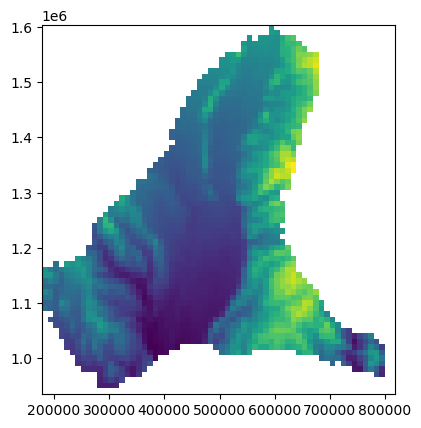

In [18]:
gisutils.projection.project_raster(rasterfile, 'output/projected_low_res.tif', 5070,
                                   resolution=1e4
                                   )
with rasterio.open('output/projected_low_res.tif') as src:
    show(src)

### Get an equivalent `pyproj.CRS` object for WTM, 3 ways:
* [`pyproj.CRS`](https://pyproj4.github.io/pyproj/stable/examples.html#using-crs) allows for simple and robust specification and comparison of CRS

  
#### using a PROJ string
([Not recommended anymore](https://pyproj4.github.io/pyproj/stable/gotchas.html#what-is-the-best-format-to-store-the-crs-information))

In [19]:
proj_str_3070 = (('+proj=tmerc +lat_0=0 +lon_0=-90 +k=0.9996 '
                 '+x_0=520000 +y_0=-4480000 +ellps=GRS80 '
                 '+datum=NAD83  +units=m +no_defs'))

In [20]:
crs_3070 = gisutils.get_authority_crs(proj_str_3070)
crs_3070

<Projected CRS: EPSG:3070>
Name: NAD83 / Wisconsin Transverse Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Wisconsin.
- bounds: (-92.89, 42.48, -86.25, 47.31)
Coordinate Operation:
- name: Wisconsin Transverse Mercator 83
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

#### The proj4 and EPSG representations are correctly identified as the same!

In [21]:
crs_3070 == gisutils.get_authority_crs(3070)

True

In [22]:
wkt_3070 = ('PROJCS["NAD83 / Wisconsin Transverse Mercator",'
            'GEOGCS["GCS_North_American_1983",'
            'DATUM["D_North_American_1983",'
            'SPHEROID["GRS_1980",6378137,298.257222101]],'
            'PRIMEM["Greenwich",0],'
            'UNIT["Degree",0.017453292519943295]],'
            'PROJECTION["Transverse_Mercator"],'
            'PARAMETER["latitude_of_origin",0],'
            'PARAMETER["central_meridian",-90],'
            'PARAMETER["scale_factor",0.9996],'
            'PARAMETER["false_easting",520000],'
            'PARAMETER["false_northing",-4480000],'
            'UNIT["Meter",1]]')

#### works for WKT too
* note that there are many different flavors of WKT; for WTM, [spatialreference.org lists at least 3](https://spatialreference.org/ref/epsg/3070/)

In [23]:
crs_3070 == gisutils.get_authority_crs(wkt_3070)

True

## Working with Rasters

#### get the crs for a raster
(as a [``pyproj.CRS``](https://pyproj4.github.io/pyproj/stable/api/crs/crs.html) instance)

In [24]:
gisutils.raster.get_raster_crs(rasterfile)

<Projected CRS: EPSG:5070>
Name: NAD83 / Conus Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-124.79, 24.41, -66.91, 49.38)
Coordinate Operation:
- name: Conus Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### Sample raster values at a set of points
For example, we can make a grid of x, y locations that covers the same area as the raster in ``rasterfile``.

In [25]:
with rasterio.open(rasterfile) as src:
    print(src.meta)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': -9999.0, 'width': 634, 'height': 666, 'count': 1, 'crs': CRS.from_epsg(5070), 'transform': Affine(1000.0, 0.0, 177955.0,
       0.0, -1000.0, 1604285.0)}


#### ``gisutils.get_values_at_points()``
* takes a raster file, scalar or sequence-like x, y values
* optionally, a ``point_crs`` argument that specifies the CRS for the x, y locations, which are then reprojected to the CRS of the raster prior to sampling
* an interpolation method argument (``"nearest"`` or ``"linear"``)
* a 1D array of sampled values for each x, y is returned

In [26]:
nrow, ncol = 700, 700
x = np.arange(ncol) * 1000 + 177955.0
y = 1604285.0 - (np.arange(nrow) * 1000)[::-1]
X, Y = np.meshgrid(x, y)

sampled = gisutils.get_values_at_points(rasterfile, 
                                        x=X.ravel(), y=Y.ravel(),
                                        points_crs=None)
sampled = np.reshape(sampled, (nrow, ncol))

reading data from data/top.tif...
finished in 5.79s


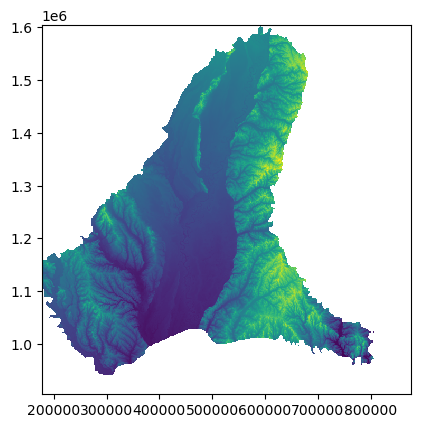

In [27]:
plt.pcolormesh(X, Y, sampled, shading='auto')
plt.gca().set_aspect(1)

### Convert a set of points to a raster
Demonstrate this by making a DataFrame of the values sampled by ``get_values_at_points()``, and then writing that out to a shapefile. Use every 10th point.

In [28]:
from shapely.geometry import Point

stride = 10
geoms = [Point(x, y) for x, y in zip(X[::stride].ravel(), Y[::stride].ravel())]
df = gp.GeoDataFrame({'geometry': geoms,
                      'elevation': sampled[::stride].ravel()},
                      crs=5070)
df.to_file('output/sampled.shp')

In [29]:
gisutils.raster.points_to_raster('output/sampled.shp',
                                 data_col='elevation',
                                 output_resolution=1000,
                                 outfile='surface.tif')


reading output/sampled.shp...
--> building dataframe... (may take a while for large shapefiles)
wrote surface.tif


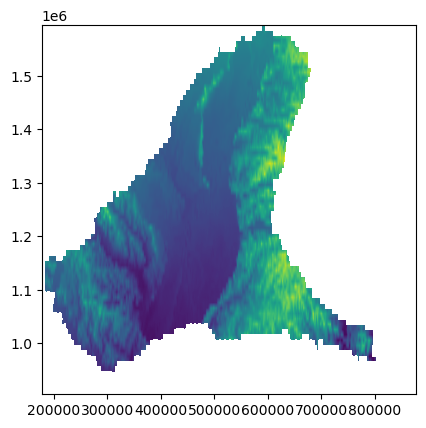

In [30]:
with rasterio.open('surface.tif') as src:
    show(src)

### Write a numpy array to a raster

First read ``rasterfile`` to an array:

In [31]:
with rasterio.open(rasterfile) as src:
    array = src.read(1)

In [32]:
array

array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       ...,
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.]])

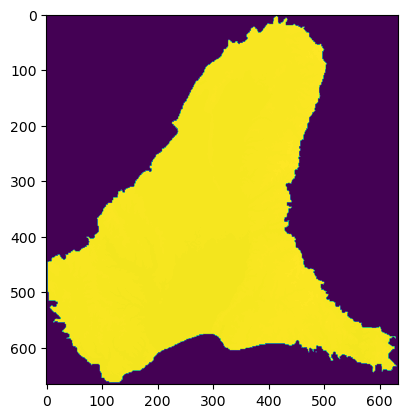

In [33]:
plt.imshow(array)

#### get the lower left corner of the array in ``rasterfile``
Note: we could simply use the upper left corner instead, via the ``xul`` and ``yul`` arguments below, but oftentimes we want to work with the lower left.

In [34]:
xll = src.transform[2]
yll = src.transform[5] + src.height * src.transform[4]
xll, yll

(177955.0, 938285.0)

#### write a raster
* with a lower left corner of xll, yll in NAD83 North American Albers (epsg:5070)
* 1,000 meter vertical and horizontal spacing
* nodata mask for all values == -9999

In [35]:
gisutils.raster.write_raster('output/surface2.tif', array, xll=xll, yll=yll,
                             dx=1000, dy=1000, rotation=0, nodata=-9999,
                             crs = 5070)

wrote output/surface2.tif


#### note that a separate ``.tif.msk`` file is written, containing the nodata mask
* this allows software like ``rasterio`` or ``QGIS`` to mask the nodata values by default

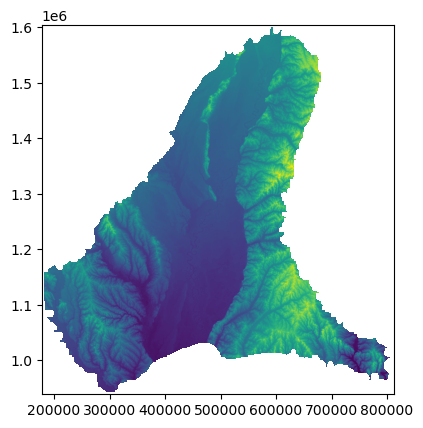

In [36]:
with rasterio.open('output/surface2.tif') as src:
    show(src)

#### alternatively, a masked array can be supplied to the same effect

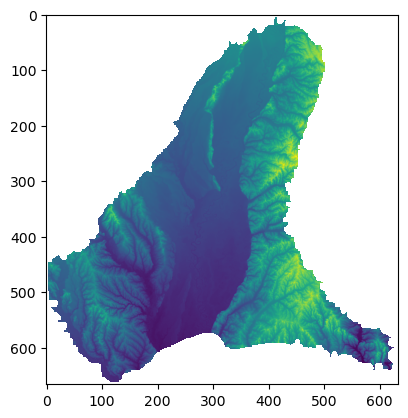

In [37]:
masked_array = np.ma.masked_array(array, array==-9999)
plt.imshow(masked_array)

In [38]:
gisutils.raster.write_raster('output/surface2.tif', masked_array, xll=xll, yll=yll,
                             dx=1000, dy=1000, rotation=0,
                             crs = 5070)

wrote output/surface2.tif
